In [1]:
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import transforms
from torchvision.io import read_image

plt.rcParams["savefig.bbox"] = 'tight'
torch.manual_seed(1)

import torchvision
model = torchvision.models.resnet18(pretrained=True)
model.eval()

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(denormalize(img).to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def denormalize(img):
    return img.to('cpu') * torch.Tensor([0.229, 0.224, 0.225]).view((3,1,1)) + torch.tensor([[0.485, 0.456, 0.406]]).view((3,1,1))

def prepare_plots(attr, img):
    img = denormalize(img).numpy().transpose((1,2,0)) * 255
    attr = attr.to('cpu').numpy().transpose((1,2,0))
    return attr, img

# Download an example image from the pytorch website
filename = "./data/dog.jpg"
if (not os.path.exists("./data/dog.jpg")):
    import urllib
    url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", filename)
    try: urllib.URLopener().retrieve(url, filename)
    except: urllib.request.urlretrieve(url, filename)

# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
image = Image.open(filename)
input_image = preprocess(image)

# Read the categories
with open("./data/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

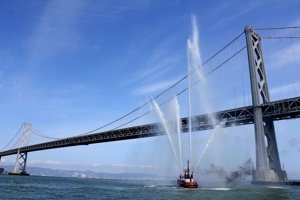

In [4]:
# sample execution (requires torchvision)
filename = "./data/fireboat.jpg"

from PIL import Image
from torchvision import transforms
image = Image.open(filename)
input_image = preprocess(image)
image.resize((v//4 for v in image.size))

In [5]:
from torch import nn

steps = 50

input_batch = input_image.unsqueeze(0) # create a mini-batch as expected by the model
label = torch.LongTensor([categories.index("Samoyed")] * (steps+1))

baseline = 0 * input_batch

if torch.cuda.is_available():
    baseline = baseline.to('cuda')
    input_batch = input_batch.to('cuda')

# Scale input and compute gradients.
scaled_inputs = [baseline + (float(i)/steps)*(input_batch-baseline) for i in range(0, steps+1)]
scaled_inputs = torch.cat(scaled_inputs)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    scaled_inputs = scaled_inputs.to('cuda')
    label = label.to('cuda')
    model.to('cuda')

# inference
scaled_inputs.requires_grad = True
output = model(scaled_inputs)

# get gradient for input
criterion = nn.CrossEntropyLoss()
criterion(output, label).backward()
grads = scaled_inputs.grad

# Use trapezoidal rule to approximate the integral.
# See Section 4 of the following paper for an accuracy comparison between
# left, right, and trapezoidal IG approximations:
# "Computing Linear Restrictions of Neural Networks", Matthew Sotoudeh, Aditya V. Thakur
# https://arxiv.org/abs/1908.06214
grads = (grads[:-1] + grads[1:]) / 2.0
avg_grads = grads.mean(0)
integrated_gradients = (input_batch-baseline) * avg_grads  # shape: <inp.shape>

C:\Users\ALIENWARE\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


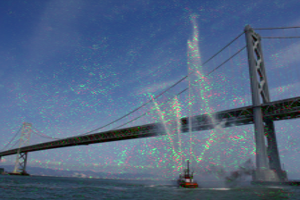

In [6]:
from VisualizationLibrary.visualization_lib import Visualize, show_pil_image, pil_image

pil_image(Visualize(
    *prepare_plots(integrated_gradients[0], input_image),
    polarity="both",
    clip_above_percentile=99,
    clip_below_percentile=0,
    overlay=True)).resize((v//4 for v in image.size))